In [1]:
import pydicom
import numpy
import os
import matplotlib.pyplot as plt
import pandas as pd

# Preprocessing Notebook

Here is a notebook to help with data preprocessing. This uses the RSNA competition data. Link to competition data: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

## Displaying Data

I'll go through a series of steps on how to display dcm data and its associated bounding box(es).

In [2]:
base_folder = '../data_vol/datasets/stage_2_train_images/'
data_files = os.listdir(base_folder)
data_files = [base_folder + file for file in data_files]
data_files[:5]

['../data_vol/datasets/stage_2_train_images/52f85606-4bd6-4947-bb43-fd2d4d1147c2.dcm',
 '../data_vol/datasets/stage_2_train_images/45f6f998-f783-4c40-b4dc-4bef22f4c503.dcm',
 '../data_vol/datasets/stage_2_train_images/f7b6c4f3-b7ea-43e5-a4b8-8e893e877ccd.dcm',
 '../data_vol/datasets/stage_2_train_images/3ca2df03-90ad-41e0-acfb-0e9dca100607.dcm',
 '../data_vol/datasets/stage_2_train_images/9e7bd306-471d-4c5c-aa53-a9d24e0779bc.dcm']

Lets display one of these files.

In [3]:
sample_files = [f for f in data_files if '00436515-870c-4b36-a041-de91049b9ab4' in f]
sample_dcm = pydicom.dcmread(sample_files[0])
print(len(sample_files))

1


In [4]:
sample_dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [5]:
sample_dcm.Rows, sample_dcm.Columns

(1024, 1024)

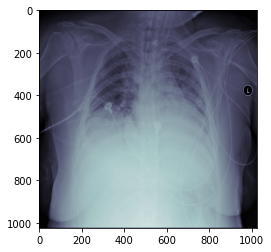

In [6]:
sample_dcm_arr = sample_dcm.pixel_array
plt.imshow(sample_dcm_arr, cmap=plt.cm.bone)
plt.show()

In [7]:
sample_dcm_arr.shape

(1024, 1024)

Lets get the label for this image and display it.

In [8]:
base_folder_labels = '../data_vol/datasets/stage_2_train_labels.csv'
label_df = pd.read_csv(base_folder_labels)
bbox_label_df = label_df.query("Target == 1")
bbox_label_df.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [9]:
sample_id = '00436515-870c-4b36-a041-de91049b9ab4'
sample_bbox = bbox_label_df.query(f"patientId == '{sample_id}'")
sample_bbox

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [10]:
bbox_coords = sample_bbox[['x', 'y', 'width', 'height']].values
bbox_coords

array([[264., 152., 213., 379.],
       [562., 152., 256., 453.]])

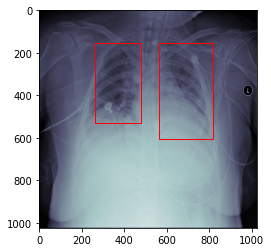

In [11]:
from matplotlib.patches import Rectangle

plt.imshow(sample_dcm_arr, cmap=plt.cm.bone)
ax = plt.gca()
for bbox_coord in bbox_coords:
    x, y, w, h = bbox_coord
    rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

Display other relevant label data

In [12]:
base_folder_metalabels = '../data_vol/datasets/stage_2_detailed_class_info.csv'
metalabel_df = pd.read_csv(base_folder_metalabels)
metalabel_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [13]:
metalabel_df.query(f"patientId == '{sample_id}'")

,patientId,class
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [14]:
metalabel_df['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

Merging tables for more descriptive metadata

In [15]:
label_df.merge(metalabel_df, on='patientId').query('Target == 1')['class'].unique()

array(['Lung Opacity'], dtype=object)

## Making JPGS out of DCMs

In [16]:
import cv2
from tqdm import tqdm

In [17]:
jpg_folder_path = '../data_vol/data/data_jpgs/'
len(os.listdir(jpg_folder_path))

26684

In [18]:
if len(os.listdir(jpg_folder_path)) == 0:
    folder_path = '../datasets/stage_2_train_images/'
    images_path = os.listdir('../datasets/stage_2_train_images/')

    for n, image in tqdm(enumerate(images_path)):
        ds = pydicom.dcmread(os.path.join(folder_path, image))
        pixel_array_numpy = ds.pixel_array
        image = image.replace('.dcm', '.jpg')

        cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)

In [ ]:
if len(os.listdir(jpg_folder_path)) == 0:
    folder_path = '../datasets/stage_2_train_images/'
    images_path = os.listdir('../datasets/stage_2_train_images/')

    for n, image in tqdm(enumerate(images_path)):
        ds = pydicom.dcmread(os.path.join(folder_path, image))
        pixel_array_numpy = ds.pixel_array
        image = image.replace('.dcm', '.jpg')

        cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)

In [19]:
# jpg_folder_path = '../filtered_datasets/data_jpgs_exist/'
# len(os.listdir(jpg_folder_path))

In [20]:
# if len(os.listdir(jpg_folder_path)) == 0:
#     folder_path = '../datasets/stage_2_train_images/'
#     images_path = os.listdir('../datasets/stage_2_train_images/')

#     for n, image in tqdm(enumerate(images_path)):
#         ds = pydicom.dcmread(os.path.join(folder_path, image))
#         pixel_array_numpy = ds.pixel_array
#         image = image.replace('.dcm', '.jpg')

#         pid = image.split(".")[0]
#         pid_df = label_df.query(f"patientId == '{pid}'")
#         if pid_df['Target'].sum() == 0:
#             continue
        
#         cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)

## PASCAL VOC Label Conversion

It might be advantageous for us to convert our labels into PASCAL VOC label format. A typical example is as follows:

```
<annotation>
	<folder>GeneratedData_Train</folder>
	<filename>000001.png</filename>
	<path>/my/path/GeneratedData_Train/000001.png</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>224</width>
		<height>224</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>21</name>
		<pose>Frontal</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>82</xmin>
			<xmax>172</xmax>
			<ymin>88</ymin>
			<ymax>146</ymax>
		</bndbox>
	</object>
</annotation>
```

An explanation of the fields can be found here: https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5

In [79]:
def make_pascal_voc(src, folder, filename, bbox_coords, img_shape):
    object_xml = ''
    
    def isNan(x):
        return x != x
    
    for bbox_coord in bbox_coords:
        x, y, w, h, target = bbox_coord
        xmin, xmax, ymin, ymax = x, x + w, y, y + h
        
        if target == 0:
            continue
            
        if xmin > xmax:
            print(src)

        object_xml += f"""\n    <object>
        <name>{target}</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <occluded>0</occluded>
        <bndbox>
            <xmin>{xmin}</xmin>
            <ymin>{ymin}</ymin>
            <xmax>{xmax}</xmax>
            <ymax>{ymax}</ymax>
        </bndbox>
    </object>"""
        
    return f"""<annotation>
    <folder>{folder}</folder>
    <filename>{filename}</filename>
    <path>{folder}/{filename}</path>
    <source>
        <database>{src}</database>
    </source>
    <size>
        <width>{img_shape[0]}</width>
        <height>{img_shape[1]}</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>{object_xml}
</annotation>"""

In [80]:
from tqdm import tqdm

pascal_voc_groups = {}
for row in tqdm(label_df.iterrows()):
    index, (pid, x, y, w, h, target) = row
    if pid not in pascal_voc_groups:
        pascal_voc_groups[pid] = []
    pascal_voc_groups[pid].append((x, y, w, h, target))

30227it [00:02, 11463.78it/s]


In [81]:
max([len(pascal_voc_groups[k]) for k in pascal_voc_groups.keys()])

4

In [82]:
from pathlib import Path


abs_folder_path = str(Path('../data/data_jpgs/').absolute().resolve())
for pid, data_row in tqdm(pascal_voc_groups.items()):
    dcm_pid = pydicom.dcmread(base_folder + pid + '.dcm')
    img_w, img_h = dcm_pid.Columns, dcm_pid.Rows
    
    if len(data_row) == 0:
        continue
    
    pv_str = make_pascal_voc(
        'kaggle_rsna',
        abs_folder_path, 
        f'{pid}.jpg', 
        data_row, (img_w, img_h))
    pv_filename = f'../data/pascal_voc_labels/{pid}.xml'
    
    with open(pv_filename, 'w') as f:
        f.write(pv_str)

100%|██████████| 26684/26684 [00:25<00:00, 1047.29it/s]


In [83]:
len(os.listdir('../data/data_jpgs/')), len(os.listdir('../data/pascal_voc_labels/'))

(26684, 26684)

In [84]:
# Checking contents of file without bounding boxes
another_sample_pid2 = 'c1cf3255-d734-4980-bfe0-967902ad7ed9'
with open(f'../data/pascal_voc_labels/{another_sample_pid2}.xml', 'r') as f:
    file_content = f.read()
print(file_content)

<annotation>
    <folder>/home/tensorflow/aeolux/data/data_jpgs</folder>
    <filename>c1cf3255-d734-4980-bfe0-967902ad7ed9.jpg</filename>
    <path>/home/tensorflow/aeolux/data/data_jpgs/c1cf3255-d734-4980-bfe0-967902ad7ed9.jpg</path>
    <source>
        <database>kaggle_rsna</database>
    </source>
    <size>
        <width>1024</width>
        <height>1024</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
</annotation>


In [85]:
# Checking contents of file with bounding boxes
another_sample_pid2 = 'bb4074e6-6327-44cd-b356-9ad42342e076'
with open(f'../data/pascal_voc_labels/{another_sample_pid2}.xml', 'r') as f:
    file_content = f.read()
print(file_content)

<annotation>
    <folder>/home/tensorflow/aeolux/data/data_jpgs</folder>
    <filename>bb4074e6-6327-44cd-b356-9ad42342e076.jpg</filename>
    <path>/home/tensorflow/aeolux/data/data_jpgs/bb4074e6-6327-44cd-b356-9ad42342e076.jpg</path>
    <source>
        <database>kaggle_rsna</database>
    </source>
    <size>
        <width>1024</width>
        <height>1024</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>1</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <occluded>0</occluded>
        <bndbox>
            <xmin>238.0</xmin>
            <ymin>535.0</ymin>
            <xmax>488.0</xmax>
            <ymax>826.0</ymax>
        </bndbox>
    </object>
    <object>
        <name>1</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <occluded>0</occluded>
        <bndbox>
            <xmin>647.0</xmin>
        

## Train Test Split

In [184]:
files = [f.split(".")[0] for f in os.listdir('../data/data_jpgs')]
data_files = ['../data/data_jpgs/' + f + '.jpg' for f in files]

In [185]:
data_files[:5]

['../data/data_jpgs/953fa799-1ba9-4e45-b4b1-2c1c39966412.jpg',
 '../data/data_jpgs/a5e84175-0226-4ab6-a5be-fd6a7c07acf5.jpg',
 '../data/data_jpgs/65d3cef8-fecc-412f-94d8-d48292757f54.jpg',
 '../data/data_jpgs/315f5455-13e6-49bf-9531-1f747d4b18d1.jpg',
 '../data/data_jpgs/c9f3a54d-48f5-4268-9306-bb7885fd2618.jpg']

In [186]:
len(data_files)

26684

In [187]:
label_files = ['../data/pascal_voc_labels/' + f + '.xml' for f in files]

In [188]:
label_files[:5]

['../data/pascal_voc_labels/953fa799-1ba9-4e45-b4b1-2c1c39966412.xml',
 '../data/pascal_voc_labels/a5e84175-0226-4ab6-a5be-fd6a7c07acf5.xml',
 '../data/pascal_voc_labels/65d3cef8-fecc-412f-94d8-d48292757f54.xml',
 '../data/pascal_voc_labels/315f5455-13e6-49bf-9531-1f747d4b18d1.xml',
 '../data/pascal_voc_labels/c9f3a54d-48f5-4268-9306-bb7885fd2618.xml']

In [189]:
len(label_files)

26684

In [190]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_files, label_files, test_size=0.2, random_state=0
)

In [191]:
from shutil import copyfile

In [192]:
for train_file, train_label in tqdm(zip(x_train, y_train), total=len(list(zip(x_train, y_train)))):
    jpg = train_file.split("/")[-1]
    lbl = train_label.split("/")[-1]
    copyfile(train_file, '../data/train/' + jpg)
    copyfile(train_label, '../data/train/' + lbl)

100%|██████████| 21347/21347 [00:04<00:00, 4546.47it/s]


In [193]:
len(x_train) + len(y_train), len(os.listdir('../data/train'))

(42694, 42694)

In [194]:
for test_file, test_label in tqdm(zip(x_test, y_test), total=len(list(zip(x_test, y_test)))):
    jpg = test_file.split("/")[-1]
    lbl = test_label.split("/")[-1]
    copyfile(test_file, '../data/test/' + jpg)
    copyfile(test_label, '../data/test/' + lbl)

100%|██████████| 5337/5337 [00:01<00:00, 4670.52it/s]


In [195]:
len(x_test) + len(y_test), len(os.listdir('../data/test'))

(10674, 10674)

In [196]:
[f for f in os.listdir('../data/train') if '00aecb01-a116-45a2-956c-08d2fa55433f' in f]

[]

In [197]:
[f for f in os.listdir('../data/test') if '00aecb01-a116-45a2-956c-08d2fa55433f' in f]

['00aecb01-a116-45a2-956c-08d2fa55433f.xml',
 '00aecb01-a116-45a2-956c-08d2fa55433f.jpg']

## Conversion to TensorFlow Records

In [198]:
import os
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET
import argparse

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow.compat.v1 as tf
from PIL import Image
from object_detection.utils import dataset_util, label_map_util
from collections import namedtuple

In [199]:
from types import SimpleNamespace

In [207]:
args = SimpleNamespace()
args.xml_dir = '../data/test'
args.image_dir = '../data/test'
args.csv_path = None
args.labels_path = './label_map.pbtxt'
args.output_path = '../data/test.record'

In [208]:
label_map = label_map_util.load_labelmap(args.labels_path)
label_map_dict = label_map_util.get_label_map_dict(label_map)

In [209]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(float(member[5][0].text)),
                     int(float(member[5][1].text)),
                     int(float(member[5][2].text)),
                     int(float(member[5][3].text))
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [210]:
def class_text_to_int(row_label):
    return label_map_dict[row_label]

In [211]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x 
            in zip(gb.groups.keys(), gb.groups)]

In [212]:
def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [213]:
writer = tf.python_io.TFRecordWriter(args.output_path)
path = os.path.join(args.image_dir)
examples = xml_to_csv(args.xml_dir)
grouped = split(examples, 'filename')
for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
writer.close()
print('Successfully created the TFRecord file: {}'.format(args.output_path))
if args.csv_path is not None:
    examples.to_csv(args.csv_path, index=None)
    print('Successfully created the CSV file: {}'.format(args.csv_path))

Successfully created the TFRecord file: ../data/test.record


In [152]:
float('544.0')

544.0